# gulf of guinea plots

adapted from CMA 2024 tutorials

## setup

In [217]:
%reload_ext jupyter_black

In [19]:
# imports
import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr


from xmip.preprocessing import combined_preprocessing
from xmip.postprocessing import _parse_metric
from datatree import DataTree

In [20]:
from tqdm import tqdm

In [21]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

plt.style.use(
    "https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle"
)

%matplotlib inline

In [22]:
# @title Helper functions


def readin_cmip6_to_datatree(facet_dict):
    # open an intake catalog containing the Pangeo CMIP cloud data
    col = intake.open_esm_datastore(
        "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    )

    # from the full `col` object, create a subset using facet search
    cat = col.search(**facet_dict)

    # convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
    kwargs = dict(
        preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
        xarray_open_kwargs=dict(
            use_cftime=True
        ),  # ensure all datasets use the same time index
        storage_options={
            "token": "anon"
        },  # anonymous/public authentication to google cloud storage
    )

    cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
    dt = cat.to_datatree(**kwargs)

    return dt


def global_mean(ds: xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(["x", "y"], keep_attrs=True)


# calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # for the coding exercise, ellipses will go after sel on the following line
        ref = dt[model]["historical"].ds.sel(time=slice("1950", "1980")).mean()
        dt_out[model] = subtree - ref
    return dt_out


def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ["historical", "ssp126"]:
            datasets.append(dt[model][experiment].ds.tos)

        da_combined = xr.concat(datasets, dim="time")

## lets load some CMIP6 data

In [34]:
col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data

In [109]:
area_of_interest = {
    "top_left": [8.5706, -1.8433],
    "bot_right": [0.1078, 12.1416],
    "lat": [8.5706, 0.1078],
    "lon": [-1.8433, 12.1416],
}
lat_max = max([8.5706, 0.1078])
lat_min = min([8.5706, 0.1078])

lon_max = max([-1.8433, 12.1416])
lon_min = min([-1.8433, 12.1416])

**first we plot interclimate variability for a single model**

this is our baseline, which we will iterate from

In [292]:
# dictionary of facets for query of surface temperature data
facet_dict = {
    "source_id": "MPI-ESM1-2-LR",
    "variable_id": "pr",
    "member_id": ["r1i1p1f1", "r2i1p1f1", "r3i1p1f1", "r4i1p1f1", "r5i1p1f1"],
    "table_id": "Amon",
    "grid_label": "gn",
    "experiment_id": ["historical", "ssp245", "ssp585"],
    "require_all_on": ["source_id", "member_id"],
}

In [293]:
dt_ensemble = readin_cmip6_to_datatree(facet_dict)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


In [309]:
def subtree_map_wet(ds):
    dry_season = [11, 12, 1, 2, 3]
    jjas = ds.time.dt.month.isin(range(6, 10))  # wet season
    ndjfm = ds.time.dt.month.isin(dry_season)  # dry season

    ds = ds.sel(y=slice(lat_min, lat_max), x=slice(lon_min, lon_max), time=jjas)
    ds = ds.mean(["x", "y"], keep_attrs=True)

    return ds


def subtree_map_dry(ds):
    dry_season = [11, 12, 1, 2, 3]
    jjas = ds.time.dt.month.isin(range(6, 10))  # wet season
    ndjfm = ds.time.dt.month.isin(dry_season)  # dry season

    ds = ds.sel(y=slice(lat_min, lat_max), x=slice(lon_min, lon_max), time=ndjfm)
    ds = ds.mean(["x", "y"], keep_attrs=True)

    return ds


def subtree_map(ds):
    ds = ds.sel(y=slice(lat_min, lat_max), x=slice(lon_min, lon_max))
    ds = ds.mean(["x", "y"], keep_attrs=True)

    return ds

Text(0.5, 0, 'Time (years)')

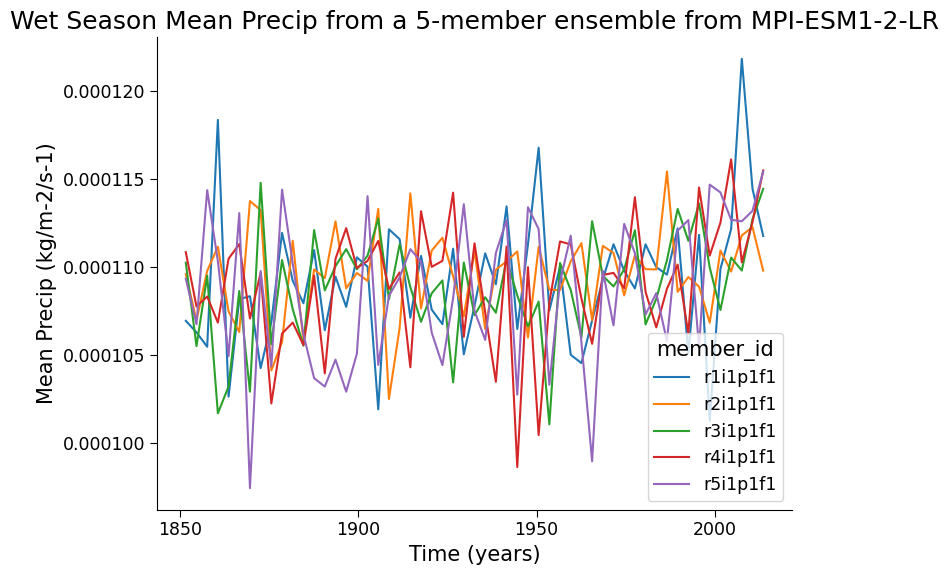

In [308]:
fig, ax = plt.subplots()

zz = dt_ensemble.map_over_subtree(subtree_map_wet)
da = zz["MPI-ESM1-2-LR"]["historical"].ds.coarsen(time=12, boundary="trim").mean().pr

_ = da.plot(hue="member_id")

ax.set_title("Wet Season Mean Precip from a 5-member ensemble from MPI-ESM1-2-LR")

# plt.axhline(0, linestyle="dashed", color="lightgrey")
ax.set_ylabel("Mean Precip (kg/m-2/s-1)")
ax.set_xlabel("Time (years)")

Text(0.5, 0, 'Time (years)')

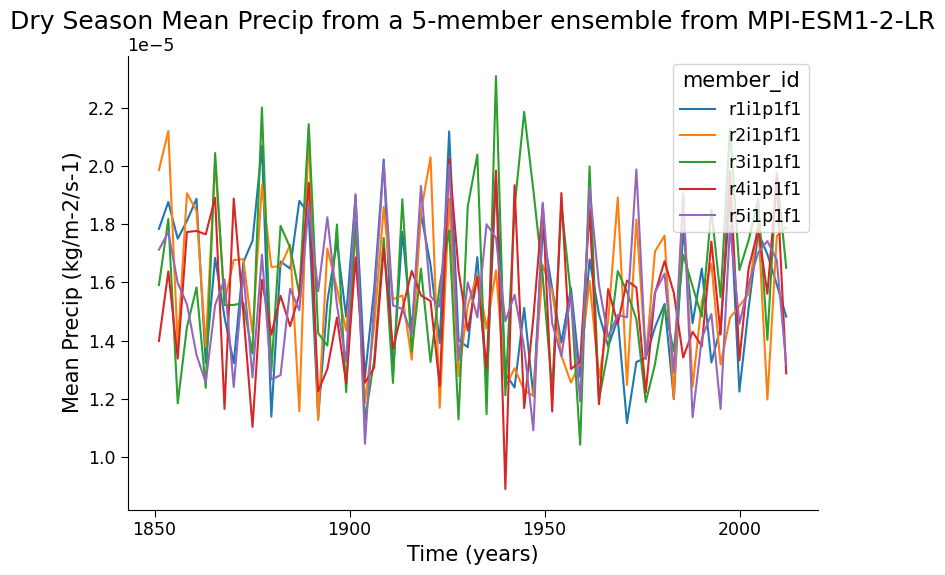

In [307]:
fig, ax = plt.subplots()

zz = dt_ensemble.map_over_subtree(subtree_map_dry)
da = zz["MPI-ESM1-2-LR"]["historical"].ds.coarsen(time=12, boundary="trim").mean().pr

_ = da.plot(hue="member_id")

ax.set_title("Dry Season Mean Precip from a 5-member ensemble from MPI-ESM1-2-LR")

# plt.axhline(0, linestyle="dashed", color="lightgrey")
ax.set_ylabel("Mean Precip (kg/m-2/s-1)")
ax.set_xlabel("Time (years)")

#### ssp585

Text(0.5, 0, 'Time (years)')

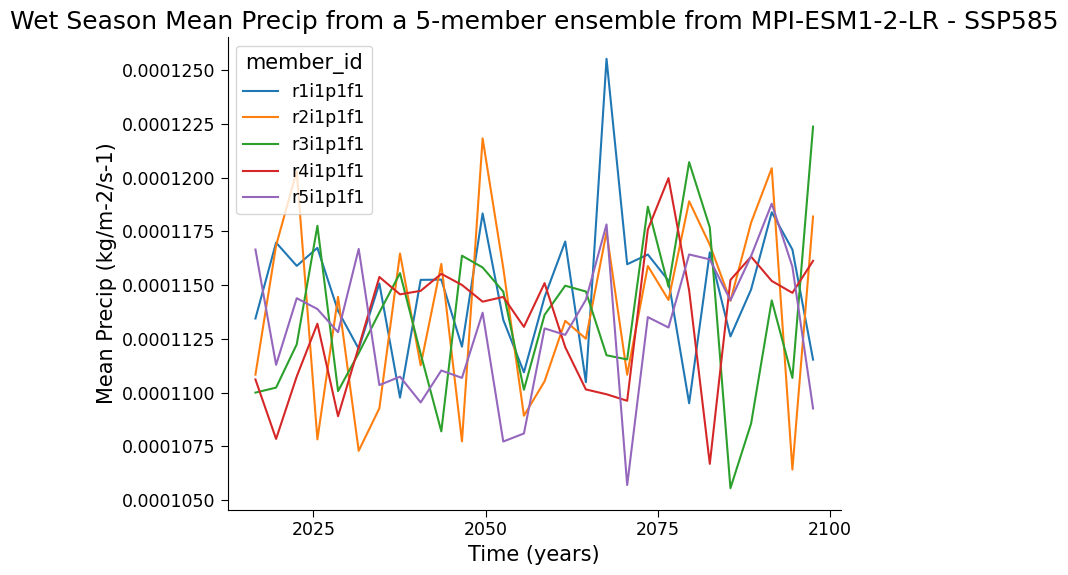

In [319]:
fig, ax = plt.subplots()

zz = dt_ensemble.map_over_subtree(subtree_map_wet)
da = zz["MPI-ESM1-2-LR"]["ssp585"].ds.coarsen(time=12, boundary="trim").mean().pr

_ = da.plot(hue="member_id")

ax.set_title(
    "Wet Season Mean Precip from a 5-member ensemble from MPI-ESM1-2-LR - SSP585"
)

# plt.axhline(0, linestyle="dashed", color="lightgrey")
ax.set_ylabel("Mean Precip (kg/m-2/s-1)")
ax.set_xlabel("Time (years)")

Text(0.5, 0, 'Time (years)')

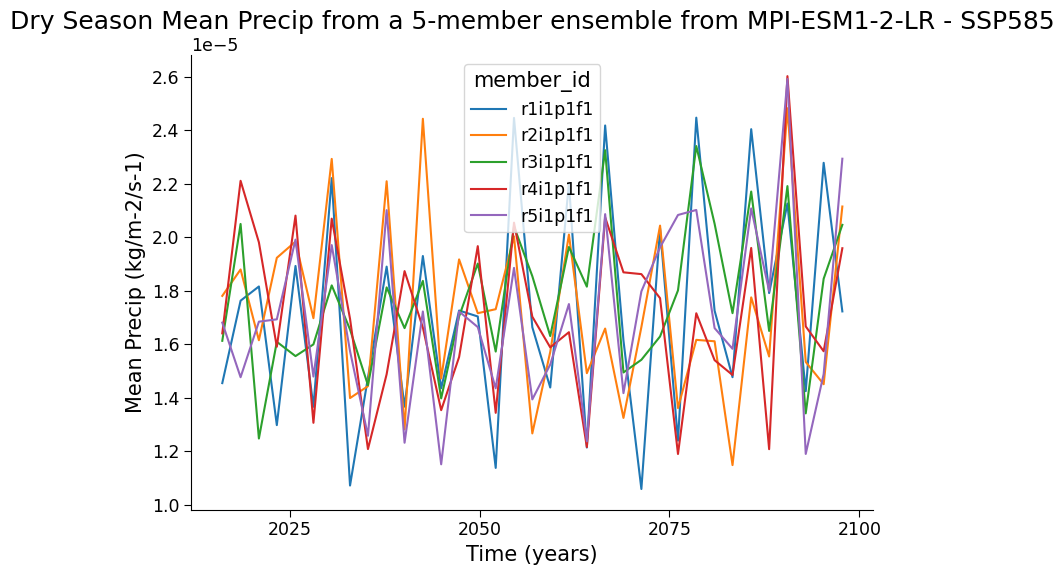

In [320]:
fig, ax = plt.subplots()

zz = dt_ensemble.map_over_subtree(subtree_map_dry)
da = zz["MPI-ESM1-2-LR"]["ssp585"].ds.coarsen(time=12, boundary="trim").mean().pr

_ = da.plot(hue="member_id")

ax.set_title(
    "Dry Season Mean Precip from a 5-member ensemble from MPI-ESM1-2-LR - SSP585"
)

# plt.axhline(0, linestyle="dashed", color="lightgrey")
ax.set_ylabel("Mean Precip (kg/m-2/s-1)")
ax.set_xlabel("Time (years)")

In [310]:
### hello

_ = ["historical", "ssp245", "ssp585"]